# 1) Implement a face detection algorithm from scratch using Haar-like features and its Integral Image computation.

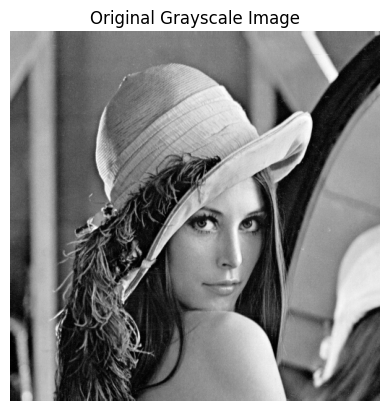

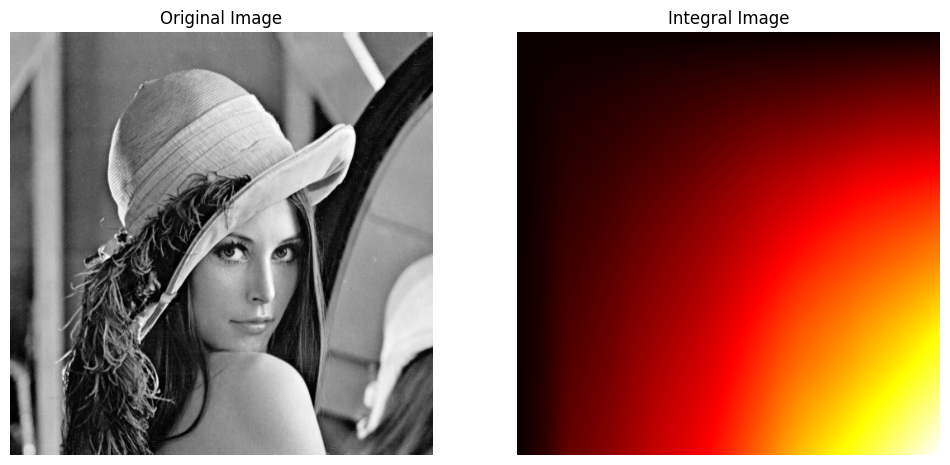

<ipython-input-2-e61e4aa21f19>:40: RuntimeWarning: overflow encountered in scalar subtract
  return D - B - C + A
<ipython-input-2-e61e4aa21f19>:40: RuntimeWarning: overflow encountered in scalar add
  return D - B - C + A


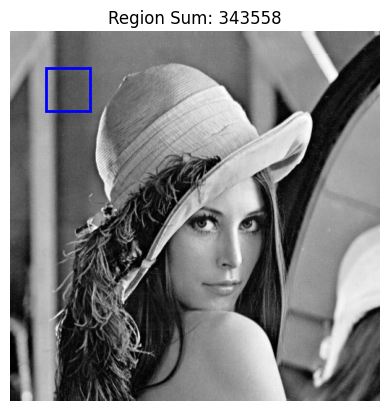

<ipython-input-2-e61e4aa21f19>:69: RuntimeWarning: overflow encountered in scalar subtract
  return white1 - black1 + white2 - black2
<ipython-input-2-e61e4aa21f19>:69: RuntimeWarning: overflow encountered in scalar add
  return white1 - black1 + white2 - black2
<ipython-input-2-e61e4aa21f19>:50: RuntimeWarning: overflow encountered in scalar subtract
  return white - black
<ipython-input-2-e61e4aa21f19>:61: RuntimeWarning: overflow encountered in scalar subtract
  return white1 - black + white2
<ipython-input-2-e61e4aa21f19>:61: RuntimeWarning: overflow encountered in scalar add
  return white1 - black + white2
<ipython-input-2-e61e4aa21f19>:55: RuntimeWarning: overflow encountered in scalar subtract
  return white - black


Face detected at (x=234, y=147, w=260, h=260)


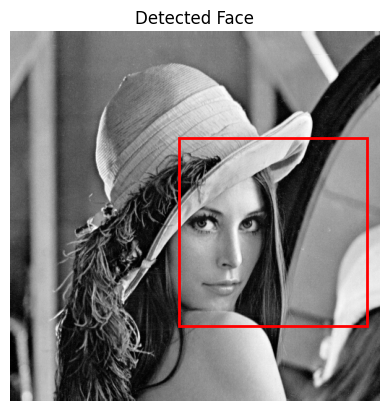

In [ ]:
import urllib.request
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

def load_image(url):
    with urllib.request.urlopen(url) as response:
        img_data = response.read()
    return Image.open(BytesIO(img_data))

def display_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def compute_integral_image(img):
    return img.cumsum(axis=0).cumsum(axis=1)

def visualize_integral_image(img, integral_img):
    # Simplified visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(integral_img, cmap='hot')
    ax[1].set_title("Integral Image")
    ax[1].axis('off')

    plt.show()

def get_region_sum(ii, x1, y1, x2, y2):
    # Cache and reuse region sum calculation
    A = ii[y1 - 1, x1 - 1] if x1 > 0 and y1 > 0 else 0
    B = ii[y1 - 1, x2] if y1 > 0 else 0
    C = ii[y2, x1 - 1] if x1 > 0 else 0
    D = ii[y2, x2]
    return D - B - C + A

def haar_feature(ii, x, y, w, h, feature_type):
    # Precompute the base region once to avoid redundant calculations
    base_sum = get_region_sum(ii, x, y, x + w - 1, y + h - 1)

    if feature_type == 'two_rect_horizontal' and w >= 2:
        half_w = w // 2
        white = get_region_sum(ii, x, y, x + half_w - 1, y + h - 1)
        black = base_sum - white
        return white - black
    elif feature_type == 'two_rect_vertical' and h >= 2:
        half_h = h // 2
        white = get_region_sum(ii, x, y, x + w - 1, y + half_h - 1)
        black = base_sum - white
        return white - black
    elif feature_type == 'three_rect_horizontal' and w >= 3:
        third_w = w // 3
        white1 = get_region_sum(ii, x, y, x + third_w - 1, y + h - 1)
        black = get_region_sum(ii, x + third_w, y, x + 2 * third_w - 1, y + h - 1)
        white2 = base_sum - (white1 + black)
        return white1 - black + white2
    elif feature_type == 'four_rect' and w >= 2 and h >= 2:
        half_w = w // 2
        half_h = h // 2
        white1 = get_region_sum(ii, x, y, x + half_w - 1, y + half_h - 1)
        black1 = get_region_sum(ii, x + half_w, y, x + w - 1, y + half_h - 1)
        white2 = get_region_sum(ii, x, y + half_h, x + half_w - 1, y + h - 1)
        black2 = base_sum - (white1 + black1 + white2)
        return white1 - black1 + white2 - black2
    return 0

def detect_face(ii, scales, win_size, step, threshold):
    height, width = ii.shape
    max_value = -np.inf
    best_face = None
    feature_types = ['two_rect_horizontal', 'two_rect_vertical', 'three_rect_horizontal', 'four_rect']

    # Precompute the window and region dimensions once outside the loop
    for scale in scales:
        scaled_w, scaled_h = int(win_size[0] * scale), int(win_size[1] * scale)
        if scaled_w > width or scaled_h > height:
            continue
        for y in range(0, height - scaled_h, step):
            for x in range(0, width - scaled_w, step):
                total = 0
                # Avoid redundant calculations by caching results
                base_sum = get_region_sum(ii, x, y, x + scaled_w - 1, y + scaled_h - 1)
                for ft in feature_types:
                    total += haar_feature(ii, x, y, scaled_w, scaled_h, ft)
                if total > max_value:
                    max_value, best_face = total, (x, y, scaled_w, scaled_h)

    if best_face and max_value > threshold:
        return best_face
    return None

def visualize_region_sum(img, integral_img, x, y, w, h):
    region_sum = get_region_sum(integral_img, x, y, x + w - 1, y + h - 1)
    plt.imshow(img, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
    plt.title(f"Region Sum: {region_sum}")
    plt.axis('off')
    plt.show()

def main():
    url = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/story_lena_lenna_1.jpg"
    image = load_image(url)
    gray_image = image.convert('L')
    gray_array = np.array(gray_image)

    display_image(gray_image, "Original Grayscale Image")

    integral_img = compute_integral_image(gray_array)
    visualize_integral_image(gray_array, integral_img)

    # Demonstrate region sum on a sample region
    visualize_region_sum(gray_array, integral_img, x=50, y=50, w=60, h=60)

    face = detect_face(
        integral_img,
        scales=[1.0, 1.2, 1.5, 1.8, 2.0],
        win_size=(130, 130),
        step=3,
        threshold=150000
    )

    if face:
        x, y, w, h = face
        print(f"Face detected at (x={x}, y={y}, w={w}, h={h})")
        plt.imshow(gray_image, cmap='gray')
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        plt.title("Detected Face")
        plt.axis('off')
        plt.show()
    else:
        print("No face detected.")

if __name__ == "__main__":
    main()


# 2) Using the raw pixel values of the face images as features. Train a Support Vector Machine (SVM) classifier on these raw pixel features to perform face recognition. Evaluate and analyze the performance of the model on the dataset

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.48      0.42      0.45       150
         1.0       0.48      0.54      0.51       150

    accuracy                           0.48       300
   macro avg       0.48      0.48      0.48       300
weighted avg       0.48      0.48      0.48       300

Confusion Matrix:
 [[63 87]
 [69 81]]


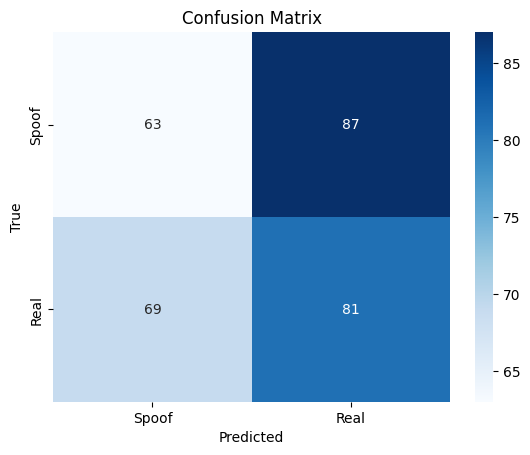

In [ ]:
from PIL import Image
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
import random
import pandas as pd

# Base URLs for real and spoof images
base_url_real = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/dataset/real/real_"
base_url_spoof = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/dataset/spoof/"

# Generate image URLs for real images
def generate_real_image_urls(base_url, ext=".jpg", count=500):
    urls = []
    for i in range(1, count + 1):
        num_str = f"{i:05}"  # Zero-padded numbers (e.g., 00001, 00002)
        urls.append(f"{base_url}{num_str}{ext}")
    return urls

# Read the spoof name list from the CSV file
spoof_name_list_url = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/spoof_name_list.csv"
spoof_names_df = pd.read_csv(spoof_name_list_url, header=None)

# Assign a column name since there is no header
spoof_names_df.columns = ['image_name']

# Select 500 unique random filenames from the spoof name list
spoof_names = spoof_names_df['image_name'].tolist()
spoof_names_500 = random.sample(spoof_names, 500)

# Generate URLs for spoof images
def generate_spoof_image_urls(base_url, names):
    urls = []
    for name in names:
        urls.append(f"{base_url}{name}")
    return urls

# Generate URLs for 500 real and 500 randomly selected spoof images
real_urls = generate_real_image_urls(base_url_real)
spoof_urls = generate_spoof_image_urls(base_url_spoof, spoof_names_500)

# Function to download and process images using PIL for binary handling
def download_images(urls, img_size=(64, 64)):
    images = []
    for url in urls:
        try:
            response = requests.get(url, stream=True)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale
                img_resized = img.resize(img_size)  # Resize the image to 64x64
                images.append(np.array(img_resized).flatten())  # Flatten the image to a 1D array
            else:
                print(f"Error loading image {url}: HTTP Status {response.status_code}")
        except Exception as e:
            print(f"Error processing image: {url} - {e}")
            continue
    return np.array(images)

# Download images
real_features = download_images(real_urls)
spoof_features = download_images(spoof_urls)

# Labels: 1 for real, 0 for spoof
real_labels = np.ones(len(real_features))
spoof_labels = np.zeros(len(spoof_features))

# Combine features and labels
X = np.vstack((real_features, spoof_features))
y = np.hstack((real_labels, spoof_labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# Assuming the images have been processed and downloaded into real_features and spoof_features

# Labels: 1 for real (face images), 0 for spoof (other images)
real_labels = np.ones(len(real_features))  # Faces
spoof_labels = np.zeros(len(spoof_features))  # Spoof

# Combine the features and labels
X = np.vstack((real_features, spoof_features))  # Combine real and spoof features
y = np.hstack((real_labels, spoof_labels))  # Combine real and spoof labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernels to try
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto']  # Kernel coefficient for RBF and polynomial
}

# Create an SVM model
svm_model = svm.SVC()

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Best Parameters: ", best_params)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Visualizing the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Real'], yticklabels=['Spoof', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# 2b: Compute LBP features and train a SVM

Extracting LBP features from images...
Training SVM with LBP features...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Training complete!
Best Parameters for LBP:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
Classification Report for LBP:
               precision    recall  f1-score   support

         0.0       0.50      0.87      0.63       150
         1.0       0.49      0.13      0.20       150

    accuracy                           0.50       300
   macro avg       0.49      0.50      0.42       300
weighted avg       0.49      0.50      0.42       300

Confusion Matrix for LBP:
 [[130  20]
 [131  19]]


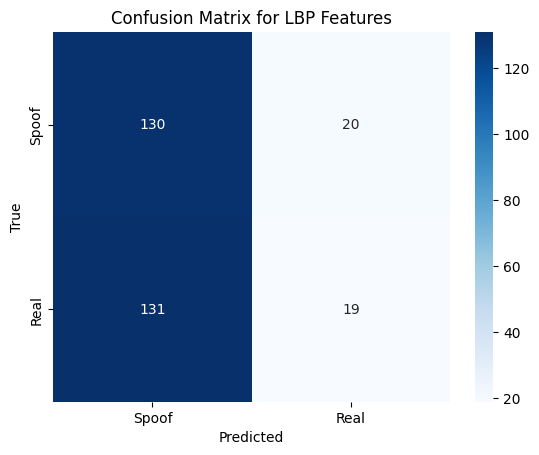

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the images are already loaded and flattened as real_features and spoof_features

# Parameters for LBP
radius = 1  # Radius for LBP calculation
n_points = 8 * radius  # Number of circularly symmetric neighbor set points

# Function to compute LBP features from an image
def compute_lbp(image, radius=1, n_points=8):
    """Compute LBP features for a given grayscale image."""
    image_reshaped = image.reshape((64, 64))  # Reshape the image back to 64x64
    lbp = local_binary_pattern(image_reshaped, n_points, radius, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize the histogram
    return hist

# Compute LBP features for both real and spoof images
print("Extracting LBP features from images...")
real_lbp = np.array([compute_lbp(image) for image in real_features])
spoof_lbp = np.array([compute_lbp(image) for image in spoof_features])

# Combine LBP features and labels
X_lbp = np.vstack((real_lbp, spoof_lbp))
y_lbp = np.hstack((real_labels, spoof_labels))

# Split the data into training and testing sets
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y_lbp, test_size=0.3, random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Create an SVM model
svm_model_lbp = svm.SVC()

# Set up GridSearchCV to find the best parameters
print("Training SVM with LBP features...")
grid_search_lbp = GridSearchCV(svm_model_lbp, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the model using GridSearchCV
grid_search_lbp.fit(X_train_lbp, y_train_lbp)

# Get the best parameters and model
best_params_lbp = grid_search_lbp.best_params_
best_model_lbp = grid_search_lbp.best_estimator_

# Make predictions on the test set
y_pred_lbp = best_model_lbp.predict(X_test_lbp)

# Evaluate the model
print("Training complete!")
print("Best Parameters for LBP: ", best_params_lbp)
print("Classification Report for LBP:\n", classification_report(y_test_lbp, y_pred_lbp))
print("Confusion Matrix for LBP:\n", confusion_matrix(y_test_lbp, y_pred_lbp))

# Visualize the confusion matrix
conf_matrix_lbp = confusion_matrix(y_test_lbp, y_pred_lbp)
sns.heatmap(conf_matrix_lbp, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Real'], yticklabels=['Spoof', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LBP Features')
plt.show()


# 2c (Edge Detection with SVM)

Extracting Sobel and Canny edge features from images...
Training SVM with Sobel edge features...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for Sobel:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report for Sobel:
               precision    recall  f1-score   support

         0.0       0.55      0.55      0.55       150
         1.0       0.55      0.54      0.54       150

    accuracy                           0.55       300
   macro avg       0.55      0.55      0.55       300
weighted avg       0.55      0.55      0.55       300

Confusion Matrix for Sobel:
 [[83 67]
 [69 81]]


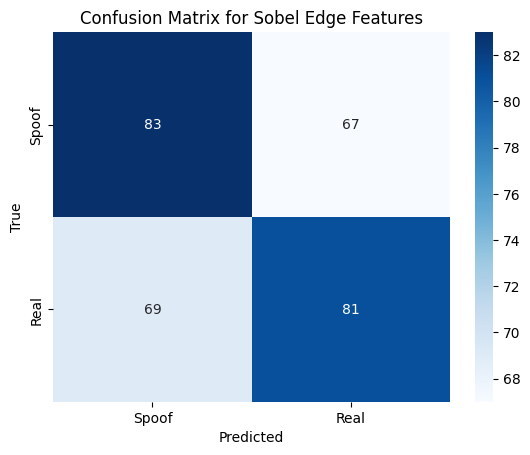

Training SVM with Canny edge features...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for Canny:  {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
Classification Report for Canny:
               precision    recall  f1-score   support

         0.0       0.61      0.55      0.58       150
         1.0       0.59      0.65      0.62       150

    accuracy                           0.60       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.60      0.60      0.60       300

Confusion Matrix for Canny:
 [[83 67]
 [53 97]]


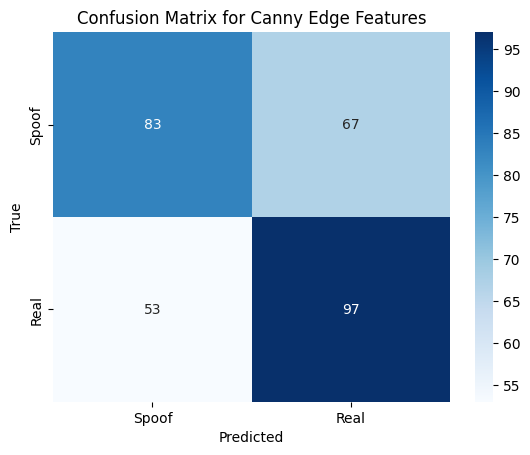

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage.filters import sobel
from skimage.feature import canny
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the images are already loaded as real_features and spoof_features (flattened 64x64 images)

# Function to compute Sobel edges
def compute_sobel_edges(image):
    image_reshaped = image.reshape((64, 64))

# Function to compute Canny edges
def compute_canny_edges(image, sigma=1.0):
    image_reshaped = image.reshape((64, 64))  #

# Compute Sobel and Canny edge features for both real and spoof images
print("Extracting Sobel and Canny edge features from images...")
real_sobel = np.array([compute_sobel_edges(image) for image in real_features])
spoof_sobel = np.array([compute_sobel_edges(image) for image in spoof_features])
real_canny = np.array([compute_canny_edges(image) for image in real_features])
spoof_canny = np.array([compute_canny_edges(image) for image in spoof_features])

# Sobel edge features
X_sobel = np.vstack((real_sobel, spoof_sobel))
y_sobel = np.hstack((real_labels, spoof_labels))

# Canny edge features
X_canny = np.vstack((real_canny, spoof_canny))
y_canny = np.hstack((real_labels, spoof_labels))

# Split the Sobel edge data into training and testing sets
X_train_sobel, X_test_sobel, y_train_sobel, y_test_sobel = train_test_split(X_sobel, y_sobel, test_size=0.3, random_state=42)

# Split the Canny edge data into training and testing sets
X_train_canny, X_test_canny, y_train_canny, y_test_canny = train_test_split(X_canny, y_canny, test_size=0.3, random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Create an SVM model for Sobel edge features
svm_model_sobel = svm.SVC()

# Set up GridSearchCV for Sobel features
print("Training SVM with Sobel edge features...")
grid_search_sobel = GridSearchCV(svm_model_sobel, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the model using Sobel edge features
grid_search_sobel.fit(X_train_sobel, y_train_sobel)

# Get the best parameters and model for Sobel features
best_params_sobel = grid_search_sobel.best_params_
best_model_sobel = grid_search_sobel.best_estimator_

# Make predictions on the test set using Sobel edge features
y_pred_sobel = best_model_sobel.predict(X_test_sobel)

# Evaluate the model for Sobel edge features
print("Best Parameters for Sobel: ", best_params_sobel)
print("Classification Report for Sobel:\n", classification_report(y_test_sobel, y_pred_sobel))
print("Confusion Matrix for Sobel:\n", confusion_matrix(y_test_sobel, y_pred_sobel))

# Visualize the confusion matrix for Sobel
conf_matrix_sobel = confusion_matrix(y_test_sobel, y_pred_sobel)
sns.heatmap(conf_matrix_sobel, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Real'], yticklabels=['Spoof', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Sobel Edge Features')
plt.show()

# Create an SVM model for Canny edge features
svm_model_canny = svm.SVC()

# Set up GridSearchCV for Canny features
print("Training SVM with Canny edge features...")
grid_search_canny = GridSearchCV(svm_model_canny, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the model using Canny edge features
grid_search_canny.fit(X_train_canny, y_train_canny)

# Get the best parameters and model for Canny features
best_params_canny = grid_search_canny.best_params_
best_model_canny = grid_search_canny.best_estimator_

# Make predictions on the test set using Canny edge features
y_pred_canny = best_model_canny.predict(X_test_canny)

# Evaluate the model for Canny edge features
print("Best Parameters for Canny: ", best_params_canny)
print("Classification Report for Canny:\n", classification_report(y_test_canny, y_pred_canny))
print("Confusion Matrix for Canny:\n", confusion_matrix(y_test_canny, y_pred_canny))

# Visualize the confusion matrix for Canny
conf_matrix_canny = confusion_matrix(y_test_canny, y_pred_canny)
sns.heatmap(conf_matrix_canny, annot=True, fmt='d', cmap='Blues', xticklabels=['Spoof', 'Real'], yticklabels=['Spoof', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Canny Edge Features')
plt.show()


# Visualization of both (Face Recognition and Edge Detection)

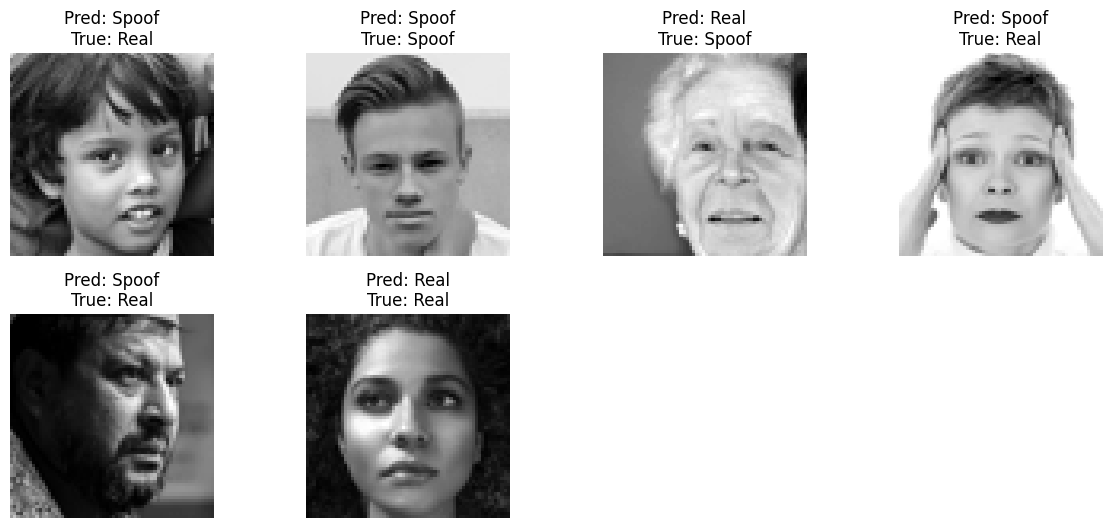

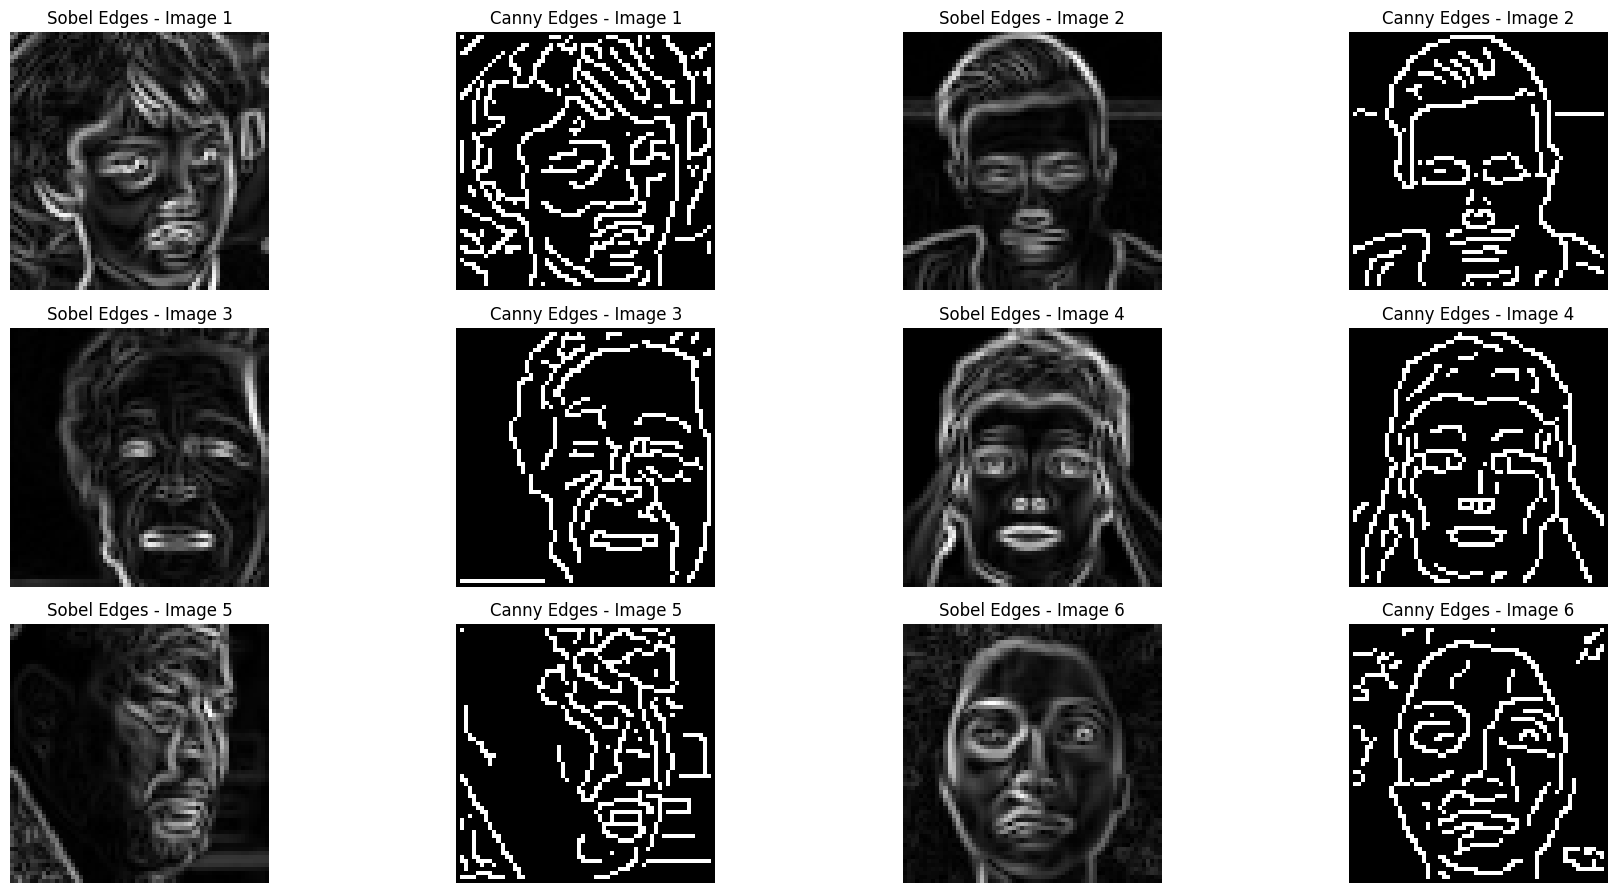

In [ ]:
import numpy as np
import requests
import pandas as pd
from io import BytesIO
from PIL import Image
import random
from skimage.filters import sobel
from skimage.feature import canny
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to download images from the provided GitHub links
def download_image(url, img_size=(64, 64)):
    """Download and process image from a given URL."""
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale
            img_resized = img.resize(img_size)  # Resize to 64x64
            return np.array(img_resized)  # Return as a numpy array
        else:
            print(f"Error loading image {url}: HTTP Status {response.status_code}")
            return None
    except Exception as e:
        print(f"Error processing image from {url}: {e}")
        return None

# Base URLs for real and spoof images
base_url_real = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/dataset/real/real_"
spoof_csv_url = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/spoof_name_list.csv"
base_url_spoof = "https://raw.githubusercontent.com/saptarshihalder/Assignment-2/refs/heads/main/dataset/spoof/"

# Read the CSV file containing spoof image names
spoof_df = pd.read_csv(spoof_csv_url, header=None, names=['image_name'])

# Randomly select 10 spoof image names from the CSV
spoof_image_names = random.sample(spoof_df['image_name'].tolist(), 10)

# Generate URLs for 10 real images and the selected 10 spoof images
real_image_urls = [f"{base_url_real}{str(i).zfill(5)}.jpg" for i in range(1, 11)]  # First 10 real images
spoof_image_urls = [f"{base_url_spoof}{name}" for name in spoof_image_names]

# Download images (both real and spoof)
real_images = [download_image(url) for url in real_image_urls]
spoof_images = [download_image(url) for url in spoof_image_urls]

# Filter out any None values in case of download failures
real_images = [img for img in real_images if img is not None]
spoof_images = [img for img in spoof_images if img is not None]

# Ensure we have 10 real and 10 spoof images
assert len(real_images) == 10, f"Expected 10 real images, but got {len(real_images)}"
assert len(spoof_images) == 10, f"Expected 10 spoof images, but got {len(spoof_images)}"

# Function to extract raw pixel features and edge features (Sobel + Canny)
def extract_features(images):
    """Extract raw pixel features and Sobel+Canny edge features from images."""
    raw_pixel_features = np.array([img.flatten() for img in images])
    sobel_features = np.array([sobel(img).flatten() for img in images])
    canny_features = np.array([canny(img, sigma=1.0).flatten() for img in images])

    # Combine all features into one dataset
    combined_features = np.hstack((raw_pixel_features, sobel_features, canny_features))
    return combined_features

# Extract features from real and spoof images
X_real = extract_features(real_images)
X_spoof = extract_features(spoof_images)

# Combine the features and create labels
X = np.vstack((X_real, X_spoof))  # Feature matrix
y = np.hstack((np.ones(len(X_real)), np.zeros(len(X_spoof))))  # Labels: 1 for real, 0 for spoof

# Combine real and spoof images for visualization
images = real_images + spoof_images

# Split into training and testing sets (images are included for visualization)
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
    X, y, images, test_size=0.3, random_state=42
)

# Train an SVM classifier
svm_model = svm.SVC(kernel='linear', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Visualization 1: Display Original Images with Predictions and True Labels
def visualize_predictions(images, predictions, labels):
    """Display original images with their predicted and true labels."""
    plt.figure(figsize=(12, 8))

    for i in range(len(images)):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        pred_label = "Real" if predictions[i] == 1 else "Spoof"
        true_label = "Real" if labels[i] == 1 else "Spoof"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualization 2: Display Sobel and Canny Edge Detections for Images
def visualize_edge_detection(images):
    """Display Sobel and Canny edge detection for test images."""
    plt.figure(figsize=(18, 12))

    for i in range(len(images)):
        sobel_edges = sobel(images[i])
        canny_edges = canny(images[i], sigma=1.0)

        plt.subplot(4, 4, i*2 + 1)
        plt.imshow(sobel_edges, cmap='gray')
        plt.title(f"Sobel Edges - Image {i+1}")
        plt.axis('off')

        plt.subplot(4, 4, i*2 + 2)
        plt.imshow(canny_edges, cmap='gray')
        plt.title(f"Canny Edges - Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show original images with predictions and true labels
visualize_predictions(images_test, y_pred, y_test)

# Show Sobel and Canny edge detection results separately
visualize_edge_detection(images_test)